# ImDb movies 

02805 Social Graphs and Interactions

Helene Hjort (s194665) & Sascha T. Jacobsen (s171281)

The cleaned dataset can be found here: https://drive.google.com/file/d/1JB-l8QhzMQbKKhOXQZmcgkFZVZLz7h0l/view?usp=sharing

## Installation of packages

In [41]:
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from fa2 import ForceAtlas2
import nltk
import os
import powerlaw
import community as community_louvain
import matplotlib.cm as cm
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator 
from PIL import Image
from operator import itemgetter
import matplotlib.lines as mlines
from itertools import count
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import *
import stylecloud
import contractions



## Cleaning the data

The data about IMDb movies is taken from the following website https://www.imdb.com/interfaces/ . The raw data consists of 5 files, 

We have cleaned the data to suit our purposes. The data contains some columns that are not necessary for our analysis, these are removed. In addition, we are only interested in movies and therefore remove rows that contain other data such as series. Further, we are only interested in movies from the US where category is actor or actress, as the majority of reviews are from the US.

Once the desired cleaning is achieved, the 5 datasets are merged to get one total dataframe.

The cleaning of the data is commented out as we have only uploaded the cleared file, so should it be necessary to run the code, you can run it after it is cleaned.


In [42]:
# We only want actor and actress
"""
links = pd.read_csv('links.tsv', sep='\t', usecols = ['tconst','nconst','category'],header=0)


links=links[(links['category']== 'actor') | (links['category']== 'actress') ]
"""

"\nlinks = pd.read_csv('links.tsv', sep='\t', usecols = ['tconst','nconst','category'],header=0)\n\n\nlinks=links[(links['category']== 'actor') | (links['category']== 'actress') ]\n"

In [43]:
# we only want movies from US
"""
types= pd.read_csv('types.tsv', sep='\t', header=0,usecols = ['titleId','title','region', 'types'])
types.columns = ['tconst','title','region', 'types']

types=types[((types['region']== 'US') ) & (types['types']=='imdbDisplay')]
"""

"\ntypes= pd.read_csv('types.tsv', sep='\t', header=0,usecols = ['titleId','title','region', 'types'])\ntypes.columns = ['tconst','title','region', 'types']\n\ntypes=types[((types['region']== 'US') ) & (types['types']=='imdbDisplay')]\n"

In [44]:
#ratings= pd.read_csv('ratings.tsv', sep='\t', header=0)

In [45]:
#names = pd.read_csv('names.tsv', sep='\t',usecols = ['nconst','primaryName', 'birthYear', 'deathYear'], header=0)

In [46]:
#title = pd.read_csv('title.tsv', sep='\t',usecols = ['tconst','primaryTitle','genres','startYear'], header=0)

In [47]:
# Combine the data, to one dataframe
"""
combine = links.merge(types, on = 'tconst')
combine = combine.drop(columns=['region', 'types'])
combine = combine.merge(ratings, on = 'tconst')
combine = combine.merge(title, on = 'tconst')
combine = combine.merge(names, on = 'nconst')
"""

"\ncombine = links.merge(types, on = 'tconst')\ncombine = combine.drop(columns=['region', 'types'])\ncombine = combine.merge(ratings, on = 'tconst')\ncombine = combine.merge(title, on = 'tconst')\ncombine = combine.merge(names, on = 'nconst')\n"

In [48]:
#There are some duplicates in the data, where the title is spelt different, we remove these dublicates

#combine=combine.drop_duplicates(subset=['tconst', 'nconst','category','averageRating', 'numVotes','primaryTitle','genres','primaryName'], keep='last')

As text, we use reviews for the movies . This data is found via the following link:
https://ai.stanford.edu/~amaas/data/sentiment/?fbclid=IwAR3lzqQKWNu1JO8GnLnDPhO3DofeDiAVPB589URGyOIXtkDzffGRq0kwMJk

Here the data is already divided into sentiment, and train, test and unsupervised. We ignore the sentiment because we will only use the text to make our own sentiment analysis. Furthermore we compile all text from train, test and unsupervised to get as much text as possible


In [49]:
"""
def Review(file,folder):
    url_link = pd.read_csv(file,names=['tconst'])

    # set the path to file
    path = folder

    text_list = []

    # go through the files in the folder
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            text = f.read()
        # append the text and filename to the empty list
        text_list.append((text, file))

    # create a dataframe to save the information
    rev_data = pd.DataFrame(text_list, columns = ['Review', 'Filename'])
    rev_data['Filename_new'] = rev_data['Filename'].str.split('_').str[0]
    url_link['Filename_new'] = url_link.index
    url_link['Filename_new'] = url_link['Filename_new'].astype(str)

    rev_df = rev_data.merge(url_link, on = 'Filename_new')

    rev_df['tconst'] = rev_df['tconst'].str.split('/usercomments').str[0]
    rev_df['tconst'] = rev_df['tconst'].str.split('title/').str[1]

    rev_df=rev_df.drop(columns=['Filename', 'Filename_new'])
    return rev_df  
"""


"\ndef Review(file,folder):\n    url_link = pd.read_csv(file,names=['tconst'])\n\n    # set the path to file\n    path = folder\n\n    text_list = []\n\n    # go through the files in the folder\n    for file in os.listdir(path):\n        with open(os.path.join(path, file)) as f:\n            text = f.read()\n        # append the text and filename to the empty list\n        text_list.append((text, file))\n\n    # create a dataframe to save the information\n    rev_data = pd.DataFrame(text_list, columns = ['Review', 'Filename'])\n    rev_data['Filename_new'] = rev_data['Filename'].str.split('_').str[0]\n    url_link['Filename_new'] = url_link.index\n    url_link['Filename_new'] = url_link['Filename_new'].astype(str)\n\n    rev_df = rev_data.merge(url_link, on = 'Filename_new')\n\n    rev_df['tconst'] = rev_df['tconst'].str.split('/usercomments').str[0]\n    rev_df['tconst'] = rev_df['tconst'].str.split('title/').str[1]\n\n    rev_df=rev_df.drop(columns=['Filename', 'Filename_new'])\n    

In [50]:
# Use the function on all the data 
"""
neg_test=Review('aclImdb/test/urls_neg.txt',r'aclImdb/test/neg')
neg_train=Review('aclImdb/train/urls_neg.txt',r'aclImdb/train/neg')
pos_test=Review('aclImdb/test/urls_pos.txt',r'aclImdb/test/pos')
pos_train=Review('aclImdb/train/urls_pos.txt',r'aclImdb/train/pos')
unsup=Review('aclImdb/train/urls_unsup.txt',r'aclImdb/train/unsup')

"""

"\nneg_test=Review('aclImdb/test/urls_neg.txt',r'aclImdb/test/neg')\nneg_train=Review('aclImdb/train/urls_neg.txt',r'aclImdb/train/neg')\npos_test=Review('aclImdb/test/urls_pos.txt',r'aclImdb/test/pos')\npos_train=Review('aclImdb/train/urls_pos.txt',r'aclImdb/train/pos')\nunsup=Review('aclImdb/train/urls_unsup.txt',r'aclImdb/train/unsup')\n\n"

In [51]:
# combine the dataframes to 1 dataframe, group by title Id, so all reviews belonging to one will be combined
"""
review=pd.concat([neg_test,neg_train, pos_test,pos_train,unsup], axis=0)

review=review.groupby('tconst').agg(lambda x: x.tolist())
review = review.reset_index(level=0)
review

"""

"\nreview=pd.concat([neg_test,neg_train, pos_test,pos_train,unsup], axis=0)\n\nreview=review.groupby('tconst').agg(lambda x: x.tolist())\nreview = review.reset_index(level=0)\nreview\n\n"

Finally, these reviews are merged on our dataset, and we only want to keep those movies that have a review.

In [52]:
#combine = combine.merge(review, on = 'tconst')

In [53]:
"""
print('There is ', combine['genres'].nunique(), ' genres.')
combine['genres'].value_counts()
"""

"\nprint('There is ', combine['genres'].nunique(), ' genres.')\ncombine['genres'].value_counts()\n"

In [54]:
# There are many genres, and many of them are very few. We therefore sort out all genres with less than 400. 
"""
combine=combine.groupby('genres').filter(lambda x : len(x)>400)
print('The data consists of top ', combine['genres'].nunique(), ' genres.')
"""

"\ncombine=combine.groupby('genres').filter(lambda x : len(x)>400)\nprint('The data consists of top ', combine['genres'].nunique(), ' genres.')\n"

In [55]:
# save the cleand data as a file
#combine.to_csv("combineBig_IMDb.csv", index = False)

## Movie Network

Our wish is to make characters as noders and movies as edges. All actors will be linked to those who have been in the same movie as them. Each node must have 2 attributes, ratings and genres. We know the rating and genre of the movie but not the character. We add a column with the rating and genre of the character. Rating is assigned based on average rating of the movies the character has participated in. The genre is given from the genre the character has participated in with the highest rating, if the character has participated in 2 genres with the same highest rating, then the one with the highest number of votes is given.


In [56]:
combine = pd.read_csv('combineBig_IMDb.csv')

In [57]:
# The popularity of an actor/ how many movies does an actor appear in
combine['name_freq']=combine['primaryName'].map(combine['primaryName'].value_counts())

In [58]:
combine

tconst     nconst category                  title  averageRating  \
0      tt0005077  nm0878035    actor  A Burlesque on Carmen            6.0   
1      tt0005077  nm0000122    actor  A Burlesque on Carmen            6.0   
2      tt0005077  nm0701012  actress  A Burlesque on Carmen            6.0   
3      tt0005077  nm0000634    actor  A Burlesque on Carmen            6.0   
4      tt0033022  nm0878035    actor            Saps at Sea            7.1   
...          ...        ...      ...                    ...            ...   
20057  tt0985051  nm2589337    actor               Garrison            3.5   
20058  tt0990404  nm2597353    actor              Chop Shop            7.2   
20059  tt0990404  nm2595487  actress              Chop Shop            7.2   
20060  tt0990404  nm2597010    actor              Chop Shop            7.2   
20061  tt0990404  nm2698343    actor              Chop Shop            7.2   

       numVotes           primaryTitle  startYear        genres  \
0          1743  A Burlesque on Carmen       1915  Comedy,Short   
1          1743  A Burlesque on Carmen       1915  Comedy,Short   
2          1743  A Burlesque on Carmen       1915  Comedy,Short   
3          1743  A Burlesque on Carmen       1915  Comedy,Short   
4          2906            Saps at Sea       1940        Comedy   
...         ...                    ...        ...           ...   
20057       287               Garrison       2008         Drama   
20058      4567              Chop Shop       2007         Drama   
20059      4567              Chop Shop       2007         Drama   
20060      4567              Chop Shop       2007         Drama   
20061      4567              Chop Shop       2007         Drama   

             primaryName birthYear deathYear  \
0             Ben Turpin      1869      1940   
1        Charles Chaplin      1889      1977   
2         Edna Purviance      1895      1958   
3          Peter Sellers      1925      1980   
4             Ben Turpin      1869      1940   
...                  ...       ...       ...   
20057      Rick Carrillo        \N        \N   
20058  Alejandro Polanco        \N        \N   
20059    Isamar Gonzales        \N        \N   
20060       Rob Sowulski        \N        \N   
20061      Carlos Zapata        \N        \N   

                                                  Review  name_freq  
0      ['Being the second last of Chaplin\'s Essanay ...          2  
1      ['Being the second last of Chaplin\'s Essanay ...         17  
2      ['Being the second last of Chaplin\'s Essanay ...          5  
3      ['Being the second last of Chaplin\'s Essanay ...          4  
4      ["SAPS AT SEA <br /><br />Aspect ratio: 1.37:1...          2  
...                                                  ...        ...  
20057  ["I've read prior comments concerning the char...          1  
20058  ['Some critics have compared Chop Shop with th...          1  
20059  ['Some critics have compared Chop Shop with th...          1  
20060  ['Some critics have compared Chop Shop with th...          1  
20061  ['Some critics have compared Chop Shop with th...          1  

[20062 rows x 14 columns]

In [59]:
# make a source - target table based on movie
sub_imdb = combine[["tconst", "nconst"]]
source_target = sub_imdb.merge(sub_imdb,on=['tconst'])
source_target = source_target[source_target['nconst_x'] != source_target['nconst_y']]
#Amount of movies actors has been in together 
source_target['weight'] = source_target.groupby(['nconst_x', 'nconst_y'])['nconst_x'].transform('size')
source_target

tconst   nconst_x   nconst_y  weight
1      tt0005077  nm0878035  nm0000122       1
2      tt0005077  nm0878035  nm0701012       1
3      tt0005077  nm0878035  nm0000634       1
4      tt0005077  nm0000122  nm0878035       1
6      tt0005077  nm0000122  nm0701012       5
...          ...        ...        ...     ...
99319  tt0990404  nm2597010  nm2595487       1
99321  tt0990404  nm2597010  nm2698343       1
99322  tt0990404  nm2698343  nm2597353       1
99323  tt0990404  nm2698343  nm2595487       1
99324  tt0990404  nm2698343  nm2597010       1

[79264 rows x 4 columns]

In [60]:
source_target['weight'].mean()

1.03910981025434

In [61]:
#Adding average rating and the relase year to the network table 
sub_imdb2 = combine[["tconst", "averageRating", "startYear"]]
source_target2 = source_target.merge(sub_imdb2,on=['tconst'])
source_target2=source_target2.drop_duplicates()

# Using the last year 2 actors played togheter
source_target2['lastYear']= source_target2.groupby(['nconst_x','nconst_y'])['startYear'].transform(max)


In [62]:
source_target2

tconst   nconst_x   nconst_y  weight  averageRating  startYear  \
0       tt0005077  nm0878035  nm0000122       1            6.0       1915   
4       tt0005077  nm0878035  nm0701012       1            6.0       1915   
8       tt0005077  nm0878035  nm0000634       1            6.0       1915   
12      tt0005077  nm0000122  nm0878035       1            6.0       1915   
16      tt0005077  nm0000122  nm0701012       5            6.0       1915   
...           ...        ...        ...     ...            ...        ...   
467640  tt0990404  nm2597010  nm2595487       1            7.2       2007   
467644  tt0990404  nm2597010  nm2698343       1            7.2       2007   
467648  tt0990404  nm2698343  nm2597353       1            7.2       2007   
467652  tt0990404  nm2698343  nm2595487       1            7.2       2007   
467656  tt0990404  nm2698343  nm2597010       1            7.2       2007   

        lastYear  
0           1915  
4           1915  
8           1915  
12          1915  
16          1916  
...          ...  
467640      2007  
467644      2007  
467648      2007  
467652      2007  
467656      2007  

[79264 rows x 7 columns]

In [63]:
#make graph, with actors as nodes, movies as links, and 'weight','averageRating' and 'lastYear' as attributes
G = nx.Graph()
G = nx.from_pandas_edgelist(source_target2, 'nconst_x', 'nconst_y', edge_attr=['weight','averageRating','lastYear'])


In [64]:
#G.edges(data=True)

In [65]:
# make dataframe of attributes
nodes = pd.DataFrame({'node' : list(combine["nconst"]),
                      'primaryName' : list(combine["primaryName"]),
                      'category' : list(combine["category"]),
                      'name_freq' : list(combine["name_freq"])
                      })
nodes =nodes.drop_duplicates()

#set primaryName as node attribute 
characterName = nodes.set_index('node')['primaryName']
nx.set_node_attributes(G, characterName, name="primaryName")

#set genres as node attribute 
cat = nodes.set_index('node')['category']
nx.set_node_attributes(G, cat, name="category")

#set primaryName frequency as node attribute 
namefreq = nodes.set_index('node')['name_freq']
nx.set_node_attributes(G, namefreq, name="name_freq")

In [66]:
#G.nodes(data=True)

In [67]:
# we only want the larges connected_components
C1= sorted(nx.connected_components(G), key=len, reverse=True)
graph=G.subgraph(C1[0]).copy()

### Statistics of graph

In [68]:
#dataframe for degree to make degree distributions
graph_degree=pd.DataFrame.from_dict(graph.degree())

fig = px.histogram(graph_degree[1], nbins=40)


fig.add_vline(x=np.mean(graph_degree[1]), line_color = 'orange', annotation_text='Mean') # line for the mean


fig.update_layout( title="Degree distributions",xaxis_title='Amount of degrees', yaxis_title='Count')

fig.show()

In [69]:
#powerlaw of degree
print(powerlaw.Fit(graph_degree[1]).alpha)

Calculating best minimal value for power law fit
6.4872929196705655


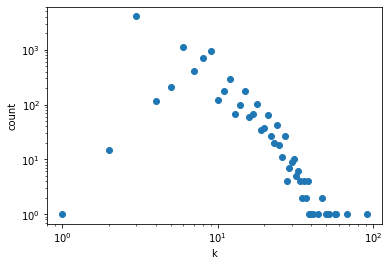

In [70]:
#log-log degree distribution
deg=list(dict(graph.degree).values())
bincount, bins = np.histogram(deg, bins=np.arange(min(graph_degree[1]),max(graph_degree[1])+1))

plt.scatter((np.arange(1,max(graph_degree[1]))), (bincount));
plt.yscale("log")
plt.xscale("log")
plt.xlabel('k');
plt.ylabel('count');

In [71]:
print("Amount of nodes", graph.number_of_nodes())
print("Amount of edges", graph.number_of_edges())
print("The average of degrees: ", np.mean(graph_degree[1]))
print("The median of degrees: ",graph_degree[1].median())
print("The most common amount of degree ",statistics.mode(graph_degree[1]))
print("Maximum of degrees: ",max(graph_degree[1]))
print("Minimum of degrees: ", min(graph_degree[1]))

Amount of nodes 9037
Amount of edges 30676
The average of degrees:  6.788978643355096
The median of degrees:  6.0
The most common amount of degree  3
Maximum of degrees:  92
Minimum of degrees:  1


### Graph

In [72]:
#node size depends on node degree
size_node = [val for (node, val) in graph.degree()]


In [73]:
# node color depends on gender
node_color = []
for node in graph :
    if graph.nodes[node]["category"]=='actress':
        node_color.append('#B22222') #red
    else:
        node_color.append('#00688B') #blue


In [74]:
#color of links depends on average rating 
rating_color = []
for edge in graph.edges :
    #bad
    if graph.get_edge_data(*edge)["averageRating"]<4:
        rating_color.append('#CD5B45') #red
    #neutral
    elif graph.get_edge_data(*edge)["averageRating"]>=4 and graph.get_edge_data(*edge)["averageRating"]<7:
        rating_color.append('#FFC125') #yellow
    #good
    else:
        rating_color.append('#A2CD5A') #green

In [75]:
#color of links depends on release date, if to actors have played in several movies, the colour is set to the last year
release_color = []

for edge in graph.edges :
    if graph.get_edge_data(*edge)["lastYear"]<1934:
        release_color.append('#3CB371') #green
    elif graph.get_edge_data(*edge)["lastYear"]>=1934 and graph.get_edge_data(*edge)["lastYear"]<1958:
        release_color.append('#00B2EE') #blue
    elif graph.get_edge_data(*edge)["lastYear"]>=1958 and graph.get_edge_data(*edge)["lastYear"]<1984:
        release_color.append('#B23AEE') #purple
    else:
        release_color.append('#FA8072') #red



In [76]:
#set label whose actor has appeared in more than 10 films together
labels = {}
for node in graph :
    if graph.nodes[node]["name_freq"]>10:
        labels[node]=graph.nodes[node]["primaryName"]
    else:
        labels[node] = ""


In [77]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # 
                          linLogMode=False,  
                          adjustSizes=False,  
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False, 

                          # Tuning
                          scalingRatio=0.002,
                          strongGravityMode=False, #
                          gravity=20,

                          # Log
                          verbose=True)

In [78]:
positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=5000)

100%|██████████| 5000/5000 [07:53<00:00, 10.55it/s]


BarnesHut Approximation  took  191.88  seconds
Repulsion forces  took  259.30  seconds
Gravitational forces  took  1.88  seconds
Attraction forces  took  1.09  seconds
AdjustSpeedAndApplyForces step  took  10.57  seconds


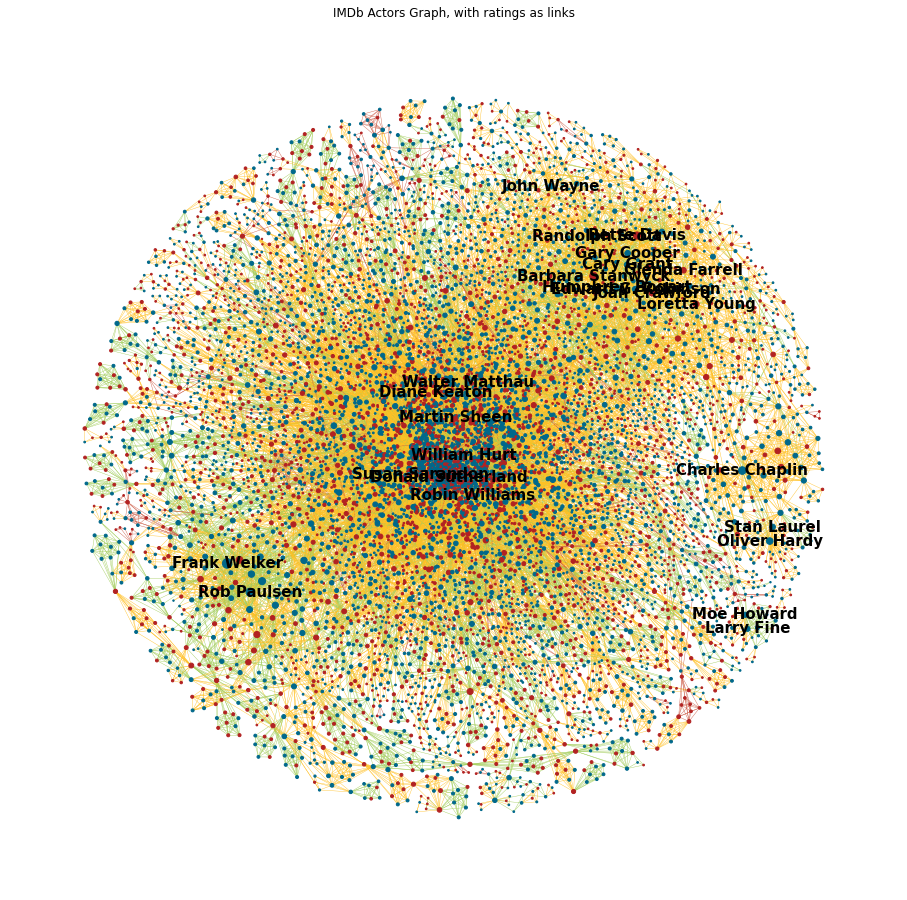

In [79]:
#ploting graph with color of links is based on average ratings


fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
nx.draw_networkx(graph, positions,  node_size =size_node, node_color = node_color, 
with_labels=True, width = 0.4, edge_color=rating_color, labels = labels, font_size = 15, font_weight= "bold")

plt.axis('off')
plt.title("IMDb Actors Graph, with ratings as links")
plt.show()

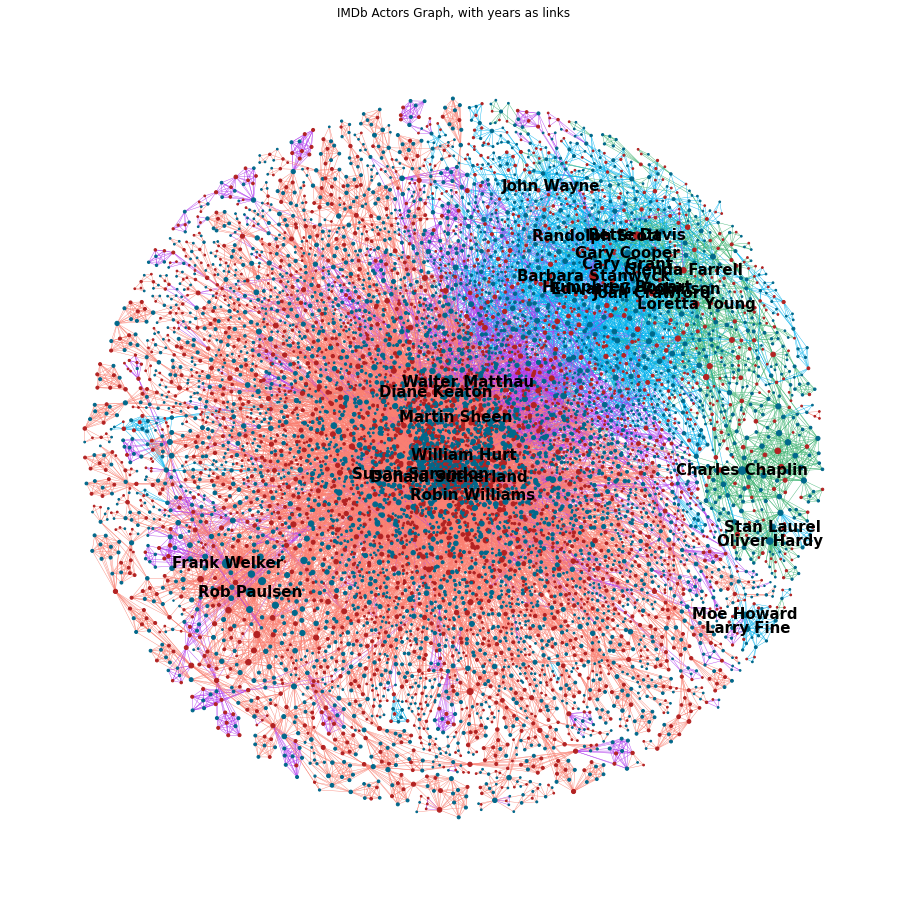

In [80]:
#ploting graph with color of links is based on year
fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
nx.draw_networkx(graph, positions,  node_size =size_node, node_color = node_color, 
with_labels=True,width = 0.4, edge_color=release_color, labels = labels, font_size = 15, font_weight= "bold")

plt.axis('off')
plt.title("IMDb Actors Graph, with years as links")
plt.show()

### Statistics 


In [81]:
#making a dict with average rating within a release year
avg_year=dict(combine.groupby('startYear')['averageRating'].mean())
lists = sorted(avg_year.items())
x, y = zip(*lists)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color='black'))

fig.add_vrect(x0="1908", x1="1935", 
              fillcolor="#3CB371", opacity=0.25, line_width=0)

fig.add_vrect(x0="1935", x1="1958", 
              fillcolor="#00B2EE", opacity=0.25, line_width=0)

fig.add_vrect(x0="1958", x1="1984", 
              fillcolor="#B23AEE", opacity=0.25, line_width=0)

fig.add_vrect(x0="1984", x1="2010", 
              fillcolor="#FA8072", opacity=0.25, line_width=0)

fig.update_layout(title='Correlation between release year and rating of movie',
    xaxis_title='Movie release year', yaxis_title='Overall average rating')

In [82]:
combine.groupby(['category'])['averageRating'].mean()

category
actor      6.088597
actress    6.040835
Name: averageRating, dtype: float64

In [83]:
#histogram of rating distibuted on gender

fig = px.histogram(combine, x='averageRating', color='category')
fig.add_vline(x=combine.groupby(['category'])['averageRating'].mean()[0], line_color = 'blue', annotation_text='Mean actor') # line for the mean
fig.add_vline(x=combine.groupby(['category'])['averageRating'].mean()[1], line_color = 'red', annotation_text='Mean actress', annotation_position="top left") # line for the mean
fig.update_layout(barmode="overlay")
fig.update_traces(opacity=0.7)

fig.update_layout(xaxis_title='Average rating', yaxis_title='Counts')

In [84]:
#cleaning the data from empty rows
sub_age=combine[["deathYear", "birthYear",'averageRating']]
sub_age =sub_age.loc[(sub_age['deathYear'].str.len() == 4) & (sub_age['birthYear'].str.len() == 4)]
sub_age['age'] = sub_age['deathYear'].astype(int) - sub_age['birthYear'].astype(int)
sub_age

#making a dict with average rating within a age of actor/actress
avg_age=dict(sub_age.groupby('age')['averageRating'].mean())
lists = sorted(avg_age.items())
x, y = zip(*lists)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Tanger Alliance'))
fig.update_layout(title='Average rating by age for actors and actresses',
    xaxis_title='Age of actor/actress', yaxis_title='Overall average rating')

In [85]:
#making a dict with average rating within notoriety
avg_namefreq=dict(combine.groupby('name_freq')['averageRating'].mean())
lists = sorted(avg_namefreq.items())
x, y = zip(*lists)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Tanger Alliance'))
fig.update_layout(title='Average rating within notoriety',
    xaxis_title='The amount of movies a person has acted in', yaxis_title='Overall average rating')

## Communities

In [86]:
# First compute the best partition
partition = community_louvain.best_partition(graph)

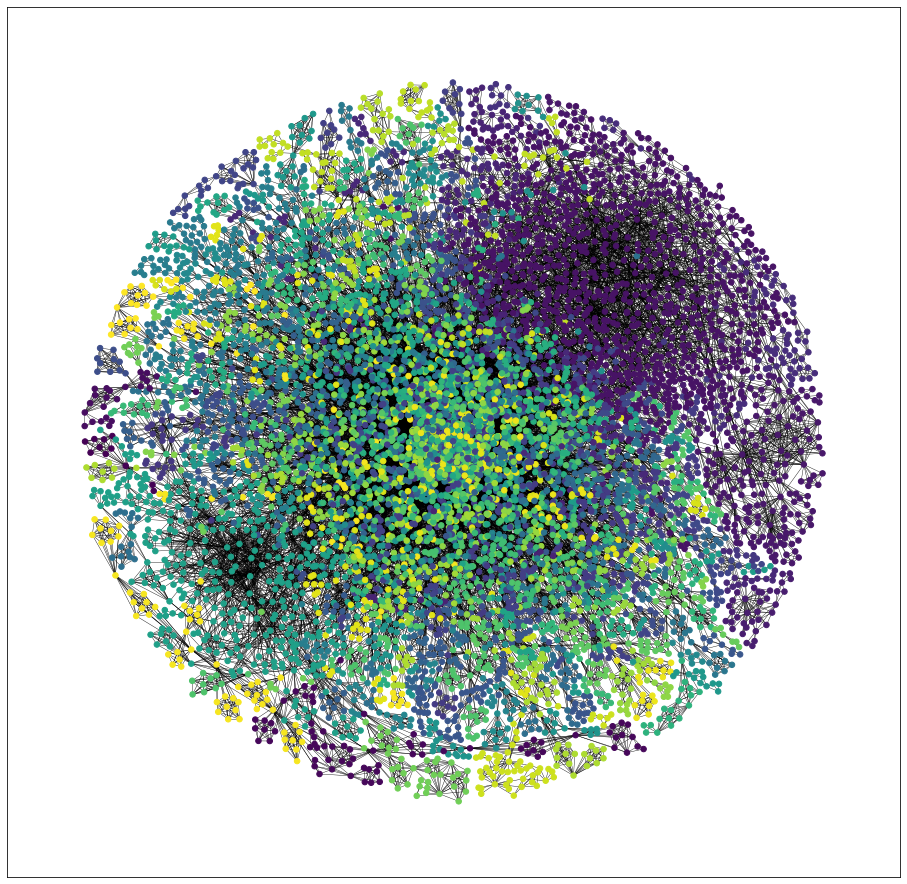

In [87]:
plt.figure(3, figsize=(16,16))

# Color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

#using the same position as the other graphs
nx.draw_networkx(graph, positions, partition.keys(),with_labels=False,width=0.4, node_size=30, cmap=cmap, node_color=list(partition.values()))

plt.show()

In [88]:
# The value of modularity for the network. 
cluster_modularity = community_louvain.modularity(partition, graph)
print('Modularity: ' + str(cluster_modularity))

Modularity: 0.8044192340399805


In [89]:
comm = {}
for key, value in partition.items():
    if value in comm:
        comm[value].append(key)
    else:
        comm[value]=[key] 
        
# Printing new dictionary after swapping

size=[]
num=[]
for key, value in sorted(comm.items()):
    size.append(len([item for item in value if item]))
    num.append(key)
    print("Community",key, "has a size of",len([item for item in value if item]))

Community 0 has a size of 11
Community 1 has a size of 73
Community 2 has a size of 24
Community 3 has a size of 1004
Community 4 has a size of 210
Community 5 has a size of 46
Community 6 has a size of 124
Community 7 has a size of 146
Community 8 has a size of 82
Community 9 has a size of 12
Community 10 has a size of 73
Community 11 has a size of 323
Community 12 has a size of 229
Community 13 has a size of 113
Community 14 has a size of 139
Community 15 has a size of 101
Community 16 has a size of 140
Community 17 has a size of 118
Community 18 has a size of 176
Community 19 has a size of 151
Community 20 has a size of 101
Community 21 has a size of 138
Community 22 has a size of 92
Community 23 has a size of 209
Community 24 has a size of 140
Community 25 has a size of 140
Community 26 has a size of 109
Community 27 has a size of 214
Community 28 has a size of 9
Community 29 has a size of 72
Community 30 has a size of 112
Community 31 has a size of 144
Community 32 has a size of 7

## Sentiment analysis and wordclouds


Before the wordclouds and sentiment scores can be created the reviews need to be cleaned from special charaters, html syntax, numeric values and lemmatized etc.

In [90]:
# Cleaning the reviews by removing html syntax
combine['clean_review'] = combine['Review'].str.replace(r'<[^<>]*>', '', regex=True)

In [91]:
# Expanding english contractions

combine["clean_review"]=combine['clean_review'].apply(lambda x: [contractions.fix(word) for word in x.split()])

combine

tconst     nconst category                  title  averageRating  \
0      tt0005077  nm0878035    actor  A Burlesque on Carmen            6.0   
1      tt0005077  nm0000122    actor  A Burlesque on Carmen            6.0   
2      tt0005077  nm0701012  actress  A Burlesque on Carmen            6.0   
3      tt0005077  nm0000634    actor  A Burlesque on Carmen            6.0   
4      tt0033022  nm0878035    actor            Saps at Sea            7.1   
...          ...        ...      ...                    ...            ...   
20057  tt0985051  nm2589337    actor               Garrison            3.5   
20058  tt0990404  nm2597353    actor              Chop Shop            7.2   
20059  tt0990404  nm2595487  actress              Chop Shop            7.2   
20060  tt0990404  nm2597010    actor              Chop Shop            7.2   
20061  tt0990404  nm2698343    actor              Chop Shop            7.2   

       numVotes           primaryTitle  startYear        genres  \
0          1743  A Burlesque on Carmen       1915  Comedy,Short   
1          1743  A Burlesque on Carmen       1915  Comedy,Short   
2          1743  A Burlesque on Carmen       1915  Comedy,Short   
3          1743  A Burlesque on Carmen       1915  Comedy,Short   
4          2906            Saps at Sea       1940        Comedy   
...         ...                    ...        ...           ...   
20057       287               Garrison       2008         Drama   
20058      4567              Chop Shop       2007         Drama   
20059      4567              Chop Shop       2007         Drama   
20060      4567              Chop Shop       2007         Drama   
20061      4567              Chop Shop       2007         Drama   

             primaryName birthYear deathYear  \
0             Ben Turpin      1869      1940   
1        Charles Chaplin      1889      1977   
2         Edna Purviance      1895      1958   
3          Peter Sellers      1925      1980   
4             Ben Turpin      1869      1940   
...                  ...       ...       ...   
20057      Rick Carrillo        \N        \N   
20058  Alejandro Polanco        \N        \N   
20059    Isamar Gonzales        \N        \N   
20060       Rob Sowulski        \N        \N   
20061      Carlos Zapata        \N        \N   

                                                  Review  name_freq  \
0      ['Being the second last of Chaplin\'s Essanay ...          2   
1      ['Being the second last of Chaplin\'s Essanay ...         17   
2      ['Being the second last of Chaplin\'s Essanay ...          5   
3      ['Being the second last of Chaplin\'s Essanay ...          4   
4      ["SAPS AT SEA <br /><br />Aspect ratio: 1.37:1...          2   
...                                                  ...        ...   
20057  ["I've read prior comments concerning the char...          1   
20058  ['Some critics have compared Chop Shop with th...          1   
20059  ['Some critics have compared Chop Shop with th...          1   
20060  ['Some critics have compared Chop Shop with th...          1   
20061  ['Some critics have compared Chop Shop with th...          1   

                                            clean_review  
0      [['Being, the, second, last, of, Chaplin\'s, E...  
1      [['Being, the, second, last, of, Chaplin\'s, E...  
2      [['Being, the, second, last, of, Chaplin\'s, E...  
3      [['Being, the, second, last, of, Chaplin\'s, E...  
4      [["SAPS, AT, SEA, Aspect, ratio:, 1.37:1Sound,...  
...                                                  ...  
20057  [["I have, read, prior, comments, concerning, ...  
20058  [['Some, critics, have, compared, Chop, Shop, ...  
20059  [['Some, critics, have, compared, Chop, Shop, ...  
20060  [['Some, critics, have, compared, Chop, Shop, ...  
20061  [['Some, critics, have, compared, Chop, Shop, ...  

[20062 rows x 15 columns]

In [92]:
# Converting clean_review back to string values
combine['clean_review'] = combine['clean_review'].apply(lambda x: ' '.join([item for item in x if len(item)>=2]))

In [93]:
#Clean the text from special characters and numericals leaving the alphabets
def clean(text):
    
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
combine['clean_review'] = combine['clean_review'].apply(clean)

In [94]:
# Cleaning the reviews by remvong trailing spaces 
combine['clean_review'] = combine['clean_review'].str.split().str.join(" ")

In [95]:
# Remove one letter words
combine['clean_review'] = combine['clean_review'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

/Users/helenehjort/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [96]:
# Lemmatizing the reviews 
wordnet_lem = WordNetLemmatizer()

combine['clean_review'] = combine['clean_review'].apply(wordnet_lem.lemmatize)

Before the sentiment scores are assigned a wordcloud for the reviews is made for overview and later comparison.

In [97]:
# The reviews are changed to lower case letter for wordcloud purposes. 
combine['cloud_review'] = combine['clean_review'].str.lower()

In [98]:
# Extraxting the full review texts as an iterable list for the wordcloud 
fulltext = ' '.join(combine['cloud_review'].tolist())
fulltext=[fulltext]

In [99]:
# Function for creating wordclouds
def wordcloud(text,color,stopword):

    # Creating the TF-IDF scores 
    tf_idf_vect = TfidfVectorizer(stop_words ='english')
    X_train_tf_idf = tf_idf_vect.fit_transform(text)
    terms = tf_idf_vect.get_feature_names_out()
    dense = X_train_tf_idf.todense()
    dlist = dense.tolist()
    tf_df = pd.DataFrame(dlist,columns=terms)

    tf_df = tf_df.drop(columns=stopword)


    #Creating the vectors
    df_vector = tf_df.T.sum(axis=1)
    
    # create a mask based on the star image
    my_mask = np.array(Image.open('star.jpg'))
    # create a wordcloud 
    wc = WordCloud(background_color='white', max_words = 50,
               mask=my_mask,
               collocations=False,
               width=600,
               height=300,colormap=color,   
               contour_width=3,
               contour_color='white')
    
 

    #Plotting the wordclouds
    Cloud = wc.generate_from_frequencies(df_vector)
    
    return Cloud 

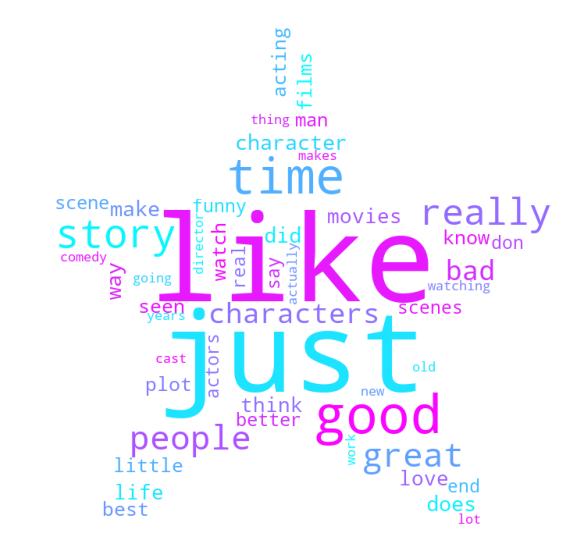

In [100]:
# Plotting wordcloud for all reviews -  the word 'film' and 'movie' are removed as they do not contribute to the analysis 
full_wordcloud = wordcloud(fulltext,'cool',['film','movie'])
plt.figure(figsize=(20, 10))
plt.imshow(full_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Trigram collocation**

In [101]:
# Bigram measures assigned to find trigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [102]:
# 'Not' is removed from stopwords to keep context 

string_full_text = ''.join(fulltext)
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not')
ignored_words = stopwords
tokens = nltk.wordpunct_tokenize(string_full_text)
#The trigrams are found
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(20)
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
scored = finder.score_ngrams(bigram_measures.raw_freq)
full_trigram = sorted(bigram for bigram, score in scored)
full_trigram

[('abc', 'http', 'www'),
 ('aboard', 'cruise', 'ship'),
 ('absolute', 'fox', 'classic'),
 ('absolute', 'must', 'see'),
 ('absolutely', 'nothing', 'else'),
 ('absolutely', 'nothing', 'going'),
 ('absolutely', 'nothing', 'happens'),
 ('absolutely', 'nothing', 'like'),
 ('absolutely', 'nothing', 'new'),
 ('academy', 'award', 'nomination'),
 ('academy', 'award', 'nominations'),
 ('academy', 'award', 'winner'),
 ('academy', 'award', 'winners'),
 ('academy', 'award', 'winning'),
 ('ace', 'ventura', 'pet'),
 ('act', 'like', 'complete'),
 ('act', 'like', 'normal'),
 ('act', 'like', 'real'),
 ('acting', 'bad', 'dialogue'),
 ('acting', 'bad', 'directing'),
 ('acting', 'bad', 'script'),
 ('acting', 'bad', 'story'),
 ('acting', 'bad', 'writing'),
 ('acting', 'could', 'not'),
 ('acting', 'like', 'idiots'),
 ('acting', 'special', 'effects'),
 ('action', 'set', 'pieces'),
 ('action', 'takes', 'place'),
 ('actor', 'turned', 'director'),
 ('actor', 'whose', 'career'),
 ('actors', 'look', 'like'),
 ('ac

### Sentiment analysis

The sentiment scores are now computed with the NTLK SentimentIntensityAnalyzer(). This model is especially good for catching sentence context such af "not good" as negative. Therefore the reviews used for calculating the score is with stopwords. Furthermore is captures intensity such as all capatilized words "GOOD", so the letters in the text is not set to all lower cases. 

In [103]:
# Creating sentiment scores for the reviews 
sid = SentimentIntensityAnalyzer()
combine['polarity'] = combine['clean_review'].apply(lambda review: sid.polarity_scores(review))

In [104]:
# Creating a new dataframe where four different four differnt columns for the sentiment score is added "neg", "neu", "pos" og "compound"
sentiment_df = pd.concat(
    [combine.drop(['numVotes', 'category', 'primaryName', 'name_freq', 'polarity'], axis=1), 
     combine['polarity'].apply(pd.Series)], axis=1)



In [105]:
sentiment_df.head()

tconst     nconst                  title  averageRating  \
0  tt0005077  nm0878035  A Burlesque on Carmen            6.0   
1  tt0005077  nm0000122  A Burlesque on Carmen            6.0   
2  tt0005077  nm0701012  A Burlesque on Carmen            6.0   
3  tt0005077  nm0000634  A Burlesque on Carmen            6.0   
4  tt0033022  nm0878035            Saps at Sea            7.1   

            primaryTitle  startYear        genres birthYear deathYear  \
0  A Burlesque on Carmen       1915  Comedy,Short      1869      1940   
1  A Burlesque on Carmen       1915  Comedy,Short      1889      1977   
2  A Burlesque on Carmen       1915  Comedy,Short      1895      1958   
3  A Burlesque on Carmen       1915  Comedy,Short      1925      1980   
4            Saps at Sea       1940        Comedy      1869      1940   

                                              Review  \
0  ['Being the second last of Chaplin\'s Essanay ...   
1  ['Being the second last of Chaplin\'s Essanay ...   
2  ['Being the second last of Chaplin\'s Essanay ...   
3  ['Being the second last of Chaplin\'s Essanay ...   
4  ["SAPS AT SEA <br /><br />Aspect ratio: 1.37:1...   

                                        clean_review  \
0  Being the second last of Chaplin Essanay films...   
1  Being the second last of Chaplin Essanay films...   
2  Being the second last of Chaplin Essanay films...   
3  Being the second last of Chaplin Essanay films...   
4  SAPS AT SEA Aspect ratio Sound format Mono Bla...   

                                        cloud_review    neg    neu    pos  \
0  being the second last of chaplin essanay films...  0.080  0.683  0.236   
1  being the second last of chaplin essanay films...  0.080  0.683  0.236   
2  being the second last of chaplin essanay films...  0.080  0.683  0.236   
3  being the second last of chaplin essanay films...  0.080  0.683  0.236   
4  saps at sea aspect ratio sound format mono bla...  0.091  0.746  0.162   

   compound  
0    0.9997  
1    0.9997  
2    0.9997  
3    0.9997  
4    0.9998

In [106]:
# Creating a column classifying the sentiment reviews as positive, neutral or negative. 
sentiment_df['sentiment'] = sentiment_df['compound'].apply(lambda x: 'Positive' if x >0 else 'Neutral' if x==0 else 'Negative')

In [107]:
# Sentiment distribution 
sentiment_df['sentiment'].value_counts()

Positive    13377
Negative     6673
Neutral        12
Name: sentiment, dtype: int64

In [108]:
# Sentiment distribution bar plot
fig = go.Figure()
fig = px.histogram(x=sentiment_df['sentiment'],text_auto=True,color=sentiment_df['sentiment'],color_discrete_sequence=px.colors.qualitative.Dark2)


fig.update_layout(title="Distributions of sentiment",xaxis_title='Sentiment category', yaxis_title='Number of reviews')

fig.show()

**Wordclouds for negative reviews**

In [109]:
#Creating new dataframe for the reviews with negative sentiment 
neg_reviews = sentiment_df.loc[sentiment_df['sentiment'] == "Negative", ["cloud_review","tconst"]]

In [110]:
neg_df = neg_reviews.drop_duplicates()

In [111]:
# Extraxting the negative text reviews as an iterable list for the wordcloud 
neg_text = ' '.join(neg_df['cloud_review'].tolist())
neg_text=[neg_text]

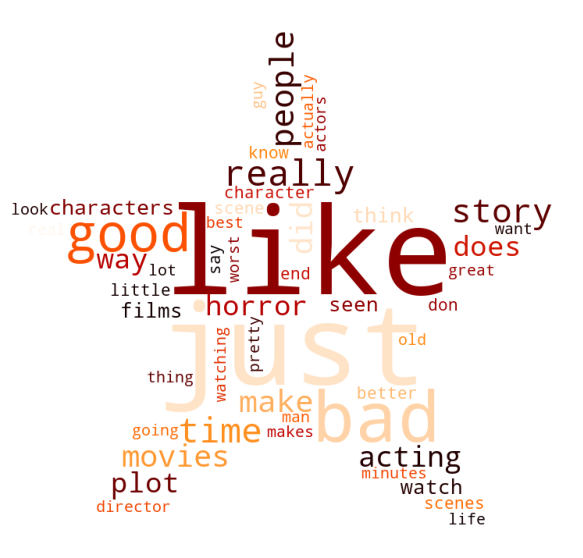

In [112]:
# Plotting wordcloud for negative reviews - in addition to removing "film" and "movie" the words "good" and "like" is
# also remvoed as they have like been used in the context "not good" or "did not like"
neg_wordcloud = wordcloud(neg_text,'gist_heat',['film','movie'])
plt.figure(figsize=(20, 10))
plt.imshow(neg_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Negative Trigram collocation**

Words like "good" and "like" at still present. However we expect this to be because they have been used in the context "not good" or "do not like". To investigate a trigram collocation analysis is made on the reviews (where stop words have not been removed). 

In [113]:
string_neg_text = ''.join(neg_text)

In [114]:
#Stopword are imported and and not is removed from them to capture context
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not')
ignored_words = stopwords
tokens = nltk.wordpunct_tokenize(string_neg_text)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(20)
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
scored = finder.score_ngrams(bigram_measures.raw_freq)
bad_trigram = sorted(bigram for bigram, score in scored)
# Sort the top most used trigrams 
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]

[(('texas', 'chainsaw', 'massacre'), 106),
 (('low', 'budget', 'horror'), 90),
 (('worst', 'movie', 'ever'), 68),
 (('low', 'budget', 'film'), 58),
 (('movie', 'ever', 'made'), 57),
 (('would', 'not', 'recommend'), 57),
 (('bad', 'acting', 'bad'), 46),
 (('new', 'york', 'city'), 45),
 (('low', 'budget', 'movie'), 43),
 (('blair', 'witch', 'project'), 42)]

In [115]:
#All trigrams for negative reviews with a frequency over 20 
bad_trigram

[('awful', 'awful', 'awful'),
 ('bad', 'acting', 'bad'),
 ('bad', 'bad', 'bad'),
 ('bad', 'horror', 'movies'),
 ('blah', 'blah', 'blah'),
 ('blair', 'witch', 'project'),
 ('chain', 'saw', 'massacre'),
 ('could', 'not', 'believe'),
 ('could', 'not', 'even'),
 ('could', 'not', 'get'),
 ('could', 'not', 'see'),
 ('could', 'not', 'stand'),
 ('dead', 'end', 'kids'),
 ('ever', 'mad', 'full'),
 ('film', 'ever', 'made'),
 ('film', 'takes', 'place'),
 ('first', 'half', 'hour'),
 ('first', 'ten', 'minutes'),
 ('greatest', 'show', 'ever'),
 ('hand', 'held', 'camera'),
 ('jamie', 'lee', 'curtis'),
 ('john', 'rhys', 'davies'),
 ('local', 'video', 'store'),
 ('low', 'budget', 'film'),
 ('low', 'budget', 'horror'),
 ('low', 'budget', 'movie'),
 ('low', 'budget', 'movies'),
 ('mad', 'full', 'stop'),
 ('movie', 'ever', 'made'),
 ('movie', 'takes', 'place'),
 ('movies', 'ever', 'made'),
 ('mystery', 'science', 'theater'),
 ('natural', 'born', 'killers'),
 ('never', 'get', 'back'),
 ('new', 'york', 'city

In [116]:
bad_trigram  = " ".join(str(x) for x in bad_trigram)

In [117]:
bad_trigram = [bad_trigram]

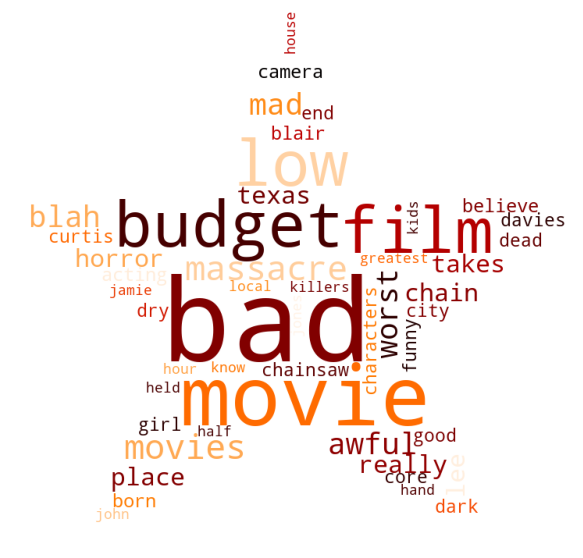

In [118]:
# Creating the TF-IDF scores 
tf_idf_vect = TfidfVectorizer(stop_words ='english')
X_train_tf_idf = tf_idf_vect.fit_transform(bad_trigram)
terms = tf_idf_vect.get_feature_names_out()
dense = X_train_tf_idf.todense()
dlist = dense.tolist()
tf_df = pd.DataFrame(dlist,columns=terms)

#tf_df = tf_df.drop(columns=stopword)


#Creating the vectors
df_vector = tf_df.T.sum(axis=1)
    
# create a mask based on the star image
my_mask = np.array(Image.open('star.jpg'))
# create a wordcloud 
wc = WordCloud(background_color='white', max_words = 50,
               mask=my_mask,
               collocations=False,
               width=600,
               height=300,colormap='gist_heat',   
               contour_width=3,
               contour_color='white')
    
 

#Plotting the wordclouds
Cloud = wc.generate_from_frequencies(df_vector)

plt.figure(figsize=(20, 10))
plt.imshow(Cloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Wordcloud for reviews with positive sentiment**

In [119]:
#Creating new dataframe for the reviews with positive sentiment 
pos_reviews = sentiment_df.loc[sentiment_df['sentiment'] == "Positive", ["cloud_review","tconst"]]

In [120]:
pos_df = pos_reviews.drop_duplicates()

In [121]:
# Extraxting text for the positive reviews as an iterable list for the wordcloud 
pos_text = ' '.join(pos_df['cloud_review'].tolist())
pos_text=[pos_text]

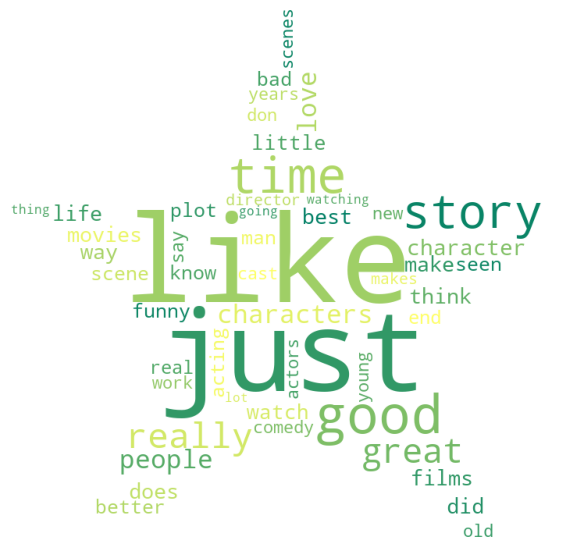

In [122]:
# Plotting wordcloud for positive reviews
pos_wordcloud = wordcloud(pos_text,'summer',['film','movie'])
plt.figure(figsize=(20, 10))
plt.imshow(pos_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Positive trigram collocation**

In [123]:
string_pos_text = ''.join(pos_text)

In [124]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not')
ignored_words = stopwords
tokens = nltk.wordpunct_tokenize(string_pos_text)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(20)
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
scored = finder.score_ngrams(bigram_measures.raw_freq)
pos_trigram = sorted(bigram for bigram, score in scored)
#Most used trigrams
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]

[(('new', 'york', 'city'), 230),
 (('two', 'main', 'characters'), 93),
 (('first', 'time', 'saw'), 78),
 (('films', 'ever', 'made'), 67),
 (('movie', 'ever', 'made'), 67),
 (('movies', 'ever', 'made'), 65),
 (('well', 'worth', 'watching'), 63),
 (('saturday', 'night', 'live'), 55),
 (('year', 'old', 'girl'), 54),
 (('well', 'worth', 'seeing'), 53)]

In [125]:
# All trigrams for positive reviews with a frequency over 20
pos_trigram

[('action', 'takes', 'place'),
 ('actually', 'pretty', 'good'),
 ('almost', 'every', 'scene'),
 ('best', 'movie', 'ever'),
 ('best', 'supporting', 'actor'),
 ('best', 'supporting', 'actress'),
 ('big', 'fat', 'greek'),
 ('blah', 'blah', 'blah'),
 ('boy', 'meets', 'girl'),
 ('catherine', 'zeta', 'jones'),
 ('charles', 'martin', 'smith'),
 ('chow', 'yun', 'fat'),
 ('cold', 'comfort', 'farm'),
 ('could', 'not', 'believe'),
 ('could', 'not', 'even'),
 ('could', 'not', 'find'),
 ('could', 'not', 'get'),
 ('could', 'not', 'help'),
 ('could', 'not', 'make'),
 ('could', 'not', 'stop'),
 ('could', 'not', 'take'),
 ('could', 'not', 'wait'),
 ('cutting', 'room', 'floor'),
 ('daniel', 'day', 'lewis'),
 ('dead', 'poets', 'society'),
 ('definitely', 'worth', 'seeing'),
 ('definitely', 'worth', 'watching'),
 ('done', 'much', 'better'),
 ('edward', 'everett', 'horton'),
 ('eight', 'title', 'brazil'),
 ('even', 'come', 'close'),
 ('every', 'time', 'see'),
 ('every', 'time', 'watch'),
 ('fat', 'greek', 

In [126]:
pos_trigram  = " ".join(str(x) for x in pos_trigram)
pos_trigram = [pos_trigram]

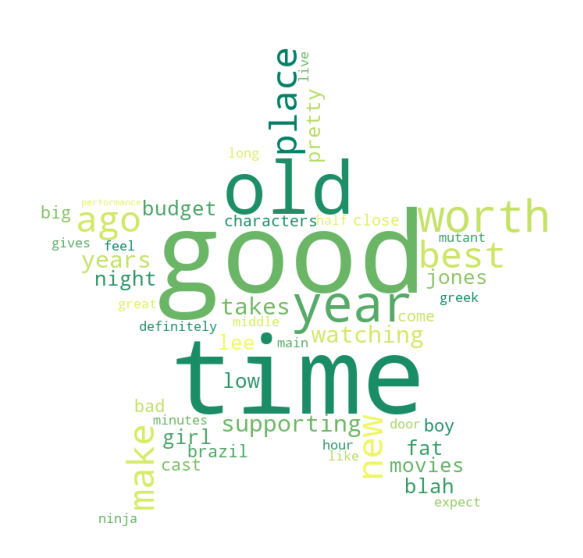

In [127]:
# Creating the TF-IDF scores 
tf_idf_vect = TfidfVectorizer(stop_words ='english')
X_train_tf_idf = tf_idf_vect.fit_transform(pos_trigram)
terms = tf_idf_vect.get_feature_names_out()
dense = X_train_tf_idf.todense()
dlist = dense.tolist()
tf_df = pd.DataFrame(dlist,columns=terms)

tf_df = tf_df.drop(columns=['movie','film'])


#Creating the vectors
df_vector = tf_df.T.sum(axis=1)
    
# create a mask based on the star image
my_mask = np.array(Image.open('star.jpg'))
# create a wordcloud 
wc = WordCloud(background_color='white', max_words = 50,
               mask=my_mask,
               collocations=False,
               width=600,
               height=300,colormap='summer',   
               contour_width=3,
               contour_color='white')
    
 

#Plotting the wordclouds
Cloud = wc.generate_from_frequencies(df_vector)

plt.figure(figsize=(20, 10))
plt.imshow(Cloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Wordcloud for reviews with neutral sentiment**

In [128]:
#Creating new dataframe for the reviews with positive sentiment 
neu_reviews = sentiment_df.loc[sentiment_df['sentiment'] == "Neutral", ["cloud_review","tconst"]]

In [129]:
neu_df = neu_reviews.drop_duplicates()

In [130]:
# Extraxting text for the positive reviews as an iterable list for the wordcloud 
neu_text = ' '.join(neu_df['cloud_review'].tolist())
neu_text=[neu_text]

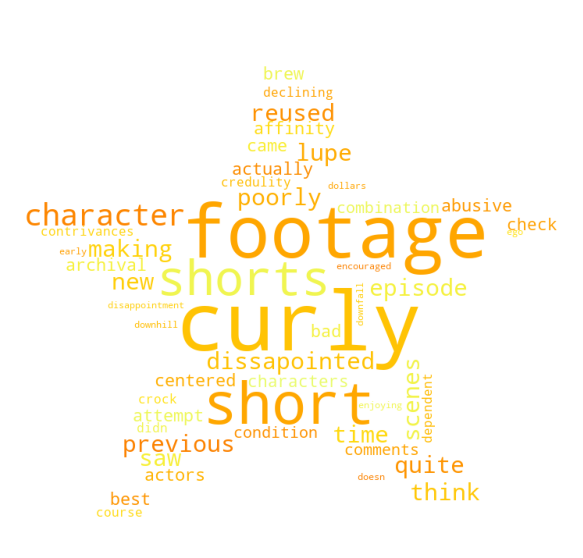

In [131]:
# Plotting wordcloud for neutral reviews
neu_wordcloud = wordcloud(neu_text,'Wistia',['movie'])
plt.figure(figsize=(20, 10))
plt.imshow(neu_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Neutral trigrams collocation**

In [132]:
string_neu_text = ''.join(neu_text)

In [133]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('not')
ignored_words = stopwords
tokens = nltk.wordpunct_tokenize(string_neu_text)
finder = TrigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(20)
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
scored = finder.score_ngrams(bigram_measures.raw_freq)
neu_trigram = sorted(bigram for bigram, score in scored)
#bad_trigram = [bad_trigram]
neu_trigram

[]

There is not enough reviews to look at trigrams with a frequency of 20, so no word cloud is made

# Wordclouds for rating categories

Wordcloud are created where the reviews are group by rating, to see if there is any indication of the rating from the wordclouds. 

In [134]:
#Group after rating 
def rating_lable (row):
   if row['averageRating'] < 4.0:
      return 'Bad rating'
   if row["averageRating"] >= 4.0 and row["averageRating"] < 7.0:
      return 'Neutral rating'
   if row['averageRating'] > 7.0:
      return 'Good rating'
   return 'Other'

In [135]:
sentiment_df['rating_lable'] = sentiment_df.apply (lambda row: rating_lable(row), axis=1)

In [136]:
sentiment_df

tconst     nconst                  title  averageRating  \
0      tt0005077  nm0878035  A Burlesque on Carmen            6.0   
1      tt0005077  nm0000122  A Burlesque on Carmen            6.0   
2      tt0005077  nm0701012  A Burlesque on Carmen            6.0   
3      tt0005077  nm0000634  A Burlesque on Carmen            6.0   
4      tt0033022  nm0878035            Saps at Sea            7.1   
...          ...        ...                    ...            ...   
20057  tt0985051  nm2589337               Garrison            3.5   
20058  tt0990404  nm2597353              Chop Shop            7.2   
20059  tt0990404  nm2595487              Chop Shop            7.2   
20060  tt0990404  nm2597010              Chop Shop            7.2   
20061  tt0990404  nm2698343              Chop Shop            7.2   

                primaryTitle  startYear        genres birthYear deathYear  \
0      A Burlesque on Carmen       1915  Comedy,Short      1869      1940   
1      A Burlesque on Carmen       1915  Comedy,Short      1889      1977   
2      A Burlesque on Carmen       1915  Comedy,Short      1895      1958   
3      A Burlesque on Carmen       1915  Comedy,Short      1925      1980   
4                Saps at Sea       1940        Comedy      1869      1940   
...                      ...        ...           ...       ...       ...   
20057               Garrison       2008         Drama        \N        \N   
20058              Chop Shop       2007         Drama        \N        \N   
20059              Chop Shop       2007         Drama        \N        \N   
20060              Chop Shop       2007         Drama        \N        \N   
20061              Chop Shop       2007         Drama        \N        \N   

                                                  Review  \
0      ['Being the second last of Chaplin\'s Essanay ...   
1      ['Being the second last of Chaplin\'s Essanay ...   
2      ['Being the second last of Chaplin\'s Essanay ...   
3      ['Being the second last of Chaplin\'s Essanay ...   
4      ["SAPS AT SEA <br /><br />Aspect ratio: 1.37:1...   
...                                                  ...   
20057  ["I've read prior comments concerning the char...   
20058  ['Some critics have compared Chop Shop with th...   
20059  ['Some critics have compared Chop Shop with th...   
20060  ['Some critics have compared Chop Shop with th...   
20061  ['Some critics have compared Chop Shop with th...   

                                            clean_review  \
0      Being the second last of Chaplin Essanay films...   
1      Being the second last of Chaplin Essanay films...   
2      Being the second last of Chaplin Essanay films...   
3      Being the second last of Chaplin Essanay films...   
4      SAPS AT SEA Aspect ratio Sound format Mono Bla...   
...                                                  ...   
20057   have read prior comments concerning the chara...   
20058  Some critics have compared Chop Shop with the ...   
20059  Some critics have compared Chop Shop with the ...   
20060  Some critics have compared Chop Shop with the ...   
20061  Some critics have compared Chop Shop with the ...   

                                            cloud_review    neg    neu    pos  \
0      being the second last of chaplin essanay films...  0.080  0.683  0.236   
1      being the second last of chaplin essanay films...  0.080  0.683  0.236   
2      being the second last of chaplin essanay films...  0.080  0.683  0.236   
3      being the second last of chaplin essanay films...  0.080  0.683  0.236   
4      saps at sea aspect ratio sound format mono bla...  0.091  0.746  0.162   
...                                                  ...    ...    ...    ...   
20057   have read prior comments concerning the chara...  0.173  0.716  0.110   
20058  some critics have compared chop shop with the ...  0.055  0.790  0.155   
20059  some critics have compared chop shop with the ...  0.055  0.790  0.155   
2006

**Wordcloud for reviews made for movies with low rating**

In [137]:
Bad_rating = sentiment_df.loc[sentiment_df['rating_lable'] == "Bad rating", ["cloud_review","tconst"]]

In [138]:
Bad_rating_df = Bad_rating.drop_duplicates()

In [139]:
# Extraxting text for the positive reviews as an iterable list for the wordcloud 
Bad_rating_text = ' '.join(Bad_rating_df['cloud_review'].tolist())
Bad_rating_text=[Bad_rating_text]

In [140]:
# New wordcloud code (copy of the other)
def star_wordcloud(text,color,stopword):

    # Creating the TF-IDF scores 
    tf_idf_vect = TfidfVectorizer(stop_words ='english')
    X_train_tf_idf = tf_idf_vect.fit_transform(text)
    terms = tf_idf_vect.get_feature_names_out()
    dense = X_train_tf_idf.todense()
    dlist = dense.tolist()
    tf_df = pd.DataFrame(dlist,columns=terms)

    tf_df = tf_df.drop(columns=stopword)


    #Creating the vectors
    df_vector = tf_df.T.sum(axis=1)
    
    # create a mask based on the popcorn image
    my_mask = np.array(Image.open('star.jpg'))
    # create a wordcloud 
    wc = WordCloud(background_color='white', max_words = 50,
               mask=my_mask,
               collocations=False,
               width=600,
               height=300,colormap=color,   
               contour_width=3,
               contour_color='white')
    

    #Plotting the wordclouds
    star_cloud = wc.generate_from_frequencies(df_vector)
    return star_cloud 

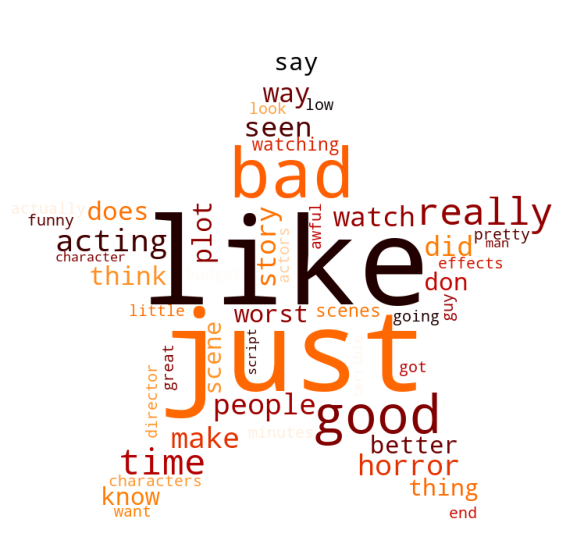

In [141]:
# Plotting wordcloud for bad rating
bad_wordcloud = star_wordcloud(Bad_rating_text,'gist_heat',['film','movie','movies','films'])
plt.figure(figsize=(20, 10))
plt.imshow(bad_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Wordcloud for reviews made for movies with neutral/medium rating**

In [142]:
Neutral_rating = sentiment_df.loc[sentiment_df['rating_lable'] == "Neutral rating", ["cloud_review","tconst"]]

In [143]:
Neutral_rating_df = Neutral_rating.drop_duplicates()

In [144]:
Neutral_rating_text = ' '.join(Neutral_rating_df['cloud_review'].tolist())
Neutral_rating_text=[Neutral_rating_text]

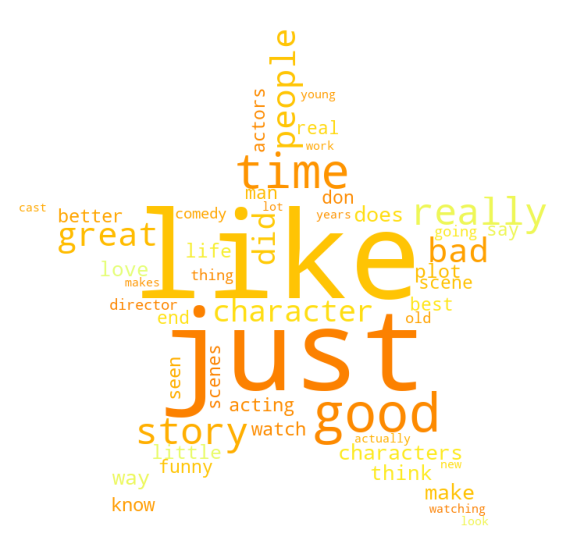

In [145]:
# Plotting wordcloud for neutral rating
neutral_wordcloud = star_wordcloud(Neutral_rating_text,'Wistia',['film','movie','movies','films'])
plt.figure(figsize=(20, 10))
plt.imshow(neutral_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

**Wordcloud for reviews made for movies with high rating**

In [146]:
Good_rating = sentiment_df.loc[sentiment_df['rating_lable'] == "Good rating", ["cloud_review","tconst"]]

In [147]:
Good_rating_df = Good_rating.drop_duplicates()

In [148]:
Good_rating_text = ' '.join(Good_rating_df['cloud_review'].tolist())
Good_rating_text=[Good_rating_text]

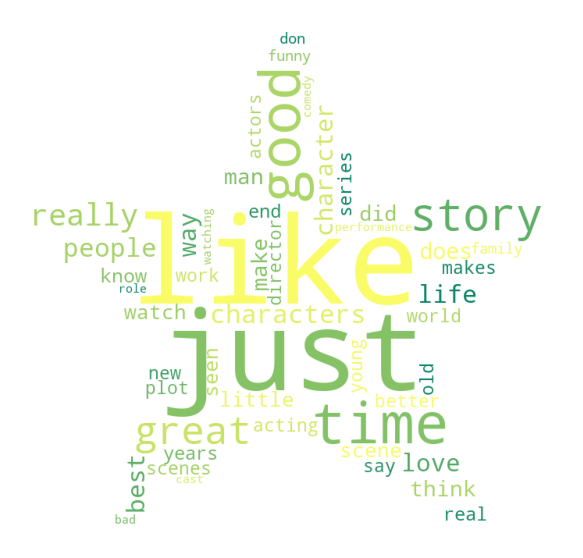

In [149]:
# Plotting wordcloud for good ratings
good_wordcloud = star_wordcloud(Good_rating_text,'summer',['film','movie','movies','films'])
plt.figure(figsize=(20, 10))
plt.imshow(good_wordcloud)
#plt.title("Reviews")
plt.axis("off")
plt.show()

## Correlation 

It is hard to make any conclussion from the wordclouds. It does not seem like there is any corraltion between sentiment and rating

In [150]:
fig = px.scatter(
    sentiment_df, x='compound', y='averageRating', hover_name='primaryTitle'
)
fig.update_layout(
    autosize=False,
    width=500,
    height=500
   
    )
fig.update_layout(
    title='Correlation between sentiment and rating of movie')